In [1]:
%load_ext autoreload
%autoreload

# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()
import os
# import some common libraries
import numpy as np
import os, json, cv2, random
import math
import matplotlib.pyplot as plt
#from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

#from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator

import sys
import glob
from detectron2.structures import BoxMode

import tqdm


from MyTrainer_valbatch import MyTrainer
from LossEvalHook import LossEvalHook

from detectron2.engine import DefaultTrainer

** fvcore version of PathManager will be deprecated soon. **
** Please migrate to the version in iopath repo. **
https://github.com/facebookresearch/iopath 

** fvcore version of PathManager will be deprecated soon. **
** Please migrate to the version in iopath repo. **
https://github.com/facebookresearch/iopath 



In [2]:
dataset_dicts ={}
import json
for d in["train","val"]:
    with open('/media/linx123-rtx/Elements/Render/YOLO custom dataset aligned (copy)/'+d+'.json', 'r') as fp:
        dataset_dicts[d] = json.load(fp)

for d in["train","val"]:
    for dic in dataset_dicts[d]:
        for anno in dic["annotations"]:
            if anno["bbox_mode"] == 0:
                anno["bbox_mode"] = BoxModeXYXY_ABS
            if anno["bbox_mode"] == 1:
                anno["bbox_mode"] = BoxMode.XYWH_ABS
            if anno["bbox_mode"] == 2:
                anno["bbox_mode"] = BoxMode.XYXY_REL
            if anno["bbox_mode"] == 3:
                anno["bbox_mode"] = BoxMode.XYWH_REL
            if anno["bbox_mode"] == 4:
                anno["bbox_mode"] = BoxMode.XYWHA_ABS

In [3]:
## REGISTER TRAIN DATASET
DatasetCatalog.register("bumblebee_" + "train", lambda d="train": dataset_dicts["train"])
MetadataCatalog.get("bumblebee_" + "train").set(thing_classes=["bumblebee"])

def get_N():
    N = 0
    for img in DatasetCatalog.get("bumblebee_train"):
        N+=len(img["annotations"] )
    return N

# CALCULATE ITERATIONS OUT OF EPOCHS
EPOCHS = 100 #epochs
BS = 16 #128, batch size (between 2...2^n...512, smaller batch sizes are better suited to smaller learning rates)
         ## DELETE OUTPUT BEFORE CHANGE, otherwise you get "Results do not correspond to current coco set" error
N = get_N()
I = 100000 #round((N / BS) * EPOCHS) # iterations


## LOAD CONFIG
cfg = get_cfg()
## batch size for validation purpose only (not training!!)


# validation
# create validation sets refering to batch size, such that val_loss can be computed every iteration on a val set according to batch size
cfg.Test_index = 0
cfg.Test_index_MAX = math.floor(len(dataset_dicts["val"]) /BS)
DatasetCatalog.register("bumblebee_" + "val", lambda d="val": dataset_dicts["val"][BS*cfg.Test_index:BS*cfg.Test_index+BS])
MetadataCatalog.get("bumblebee_" + d).set(thing_classes=["bumblebee"])

    
bumblebee_metadata = MetadataCatalog.get("bumblebee_train")

In [6]:
# lookup the config file in /home/linx123-rtx/anaconda3/envs/multi-ants-tracking/lib/python3.8/site-packages/detectron2/model_zoo/configs/
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml"))
## DEFINE DATASET IN CONFIG
cfg.DATASETS.TRAIN = ('bumblebee_train',)
cfg.DATASETS.TEST = ('bumblebee_val',)
cfg.DATALOADER.NUM_WORKERS = 4
## MODEL
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml")  # Let training initialize from model zoo

cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = BS 
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (bumblebee).

#cfg.MODEL.RETINANET.FOCAL_LOSS_GAMMA = 5.0
#cfg.MODEL.RETINANET.FOCAL_LOSS_ALPHA = 0.125
cfg.MODEL.FPN.OUT_CHANNELS = 256
cfg.MODEL.ANCHOR_GENERATOR.SIZES = [[32*0.75, 64*0.75, 128*0.75, 256*0.75, 512*0.75]]
## SOLVER
cfg.SOLVER.BASE_LR = 0.00005  # good learning rate is 0.0005 for this case, 0.000015 is to high (common is between 10^-6...1)
cfg.SOLVER.LR_POLICY = 'steps_with_decay' 
cfg.SOLVER.GAMMA = 0.5 #0.01
cfg.SOLVER.STEPS = [20000, 30000,40000,50000,60000]

cfg.SOLVER.WARMUP_ITERS = 1000 #reduce effect of early training examples
# Start the warm up from SOLVER.BASE_LR * SOLVER.WARM_UP_FACTOR
cfg.SOLVER.WARM_UP_FACTOR = 1.0 / 3.0
# WARM_UP_METHOD can be either 'constant' or 'linear' (i.e., gradual)
cfg.SOLVER.WARM_UP_METHOD = 'linear'

cfg.SOLVER.MAX_ITER = I   #adjust up if val mAP is still rising, adjust down if overfit
cfg.SOLVER.MOMENTUM = 0.9 # Momentum to use with SGD
cfg.SOLVER.IMS_PER_BATCH = 1 #2 IMS_PER_BATCH = 2 means that in 1 iteration the model sees 2 images ATTENTION: WRONG VALUE CAN LEAD TO LOWER VAL LOSS THEN TRAIN LOSS FOR SOME UNCLEAR REASON 

## TEST CONFIGS
cfg.TEST.EVAL_PERIOD = 10



#os.makedirs(cfg.OUTPUT_DIR, exist_ok=False)
trainer = MyTrainer(cfg) 
trainer.resume_or_load(resume=False)

[01/28 13:27:59 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

[01/28 13:27:59 d2.data.build]: Removed 88 images with no usable annotations. 11359 images left.
[01/28 13:27:59 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
| bumblebee  | 15624        |
|            |              |
[01/28 13:27:59 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[01/28 13:27:59 d2.data.build]: Using training sampler TrainingSampler
[01/28 13:27:59 d2.data.common]: Serializing 11359 elements to byte tensors and concatenating them all ...
[01/28 13:27:59 d2.data.common]: Serialized dataset takes 4.13 MiB
[01/28 13:27:59 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[01/28 13:27:59 d2.data.build]: 

Skip loading parameter 'proposal_generator.anchor_generator.cell_anchors.0' to the model due to incompatible shapes: (3, 4) in the checkpoint but (15, 4) in the model! You might want to double check if this is expected.
Skip loading parameter 'proposal_generator.anchor_generator.cell_anchors.1' to the model due to incompatible shapes: (3, 4) in the checkpoint but (15, 4) in the model! You might want to double check if this is expected.
Skip loading parameter 'proposal_generator.anchor_generator.cell_anchors.2' to the model due to incompatible shapes: (3, 4) in the checkpoint but (15, 4) in the model! You might want to double check if this is expected.
Skip loading parameter 'proposal_generator.anchor_generator.cell_anchors.3' to the model due to incompatible shapes: (3, 4) in the checkpoint but (15, 4) in the model! You might want to double check if this is expected.
Skip loading parameter 'proposal_generator.anchor_generator.cell_anchors.4' to the model due to incompatible shapes: (3,

In [7]:
cfg.OUTPUT_DIR = '/home/linx123-rtx/multi-ants-tracking/Detectron2_training/test'
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_0029999.pth")  # path to the model we just trained


In [20]:
def get_iou(bb1, bb2):
    """
    Calculate the Intersection over Union (IoU) of two bounding boxes.

    Parameters
    ----------
    bb1 : dict
        Keys: {'x1', 'x2', 'y1', 'y2'}
        The (x1, y1) position is at the top left corner,
        the (x2, y2) position is at the bottom right corner
    bb2 : dict
        Keys: {'x1', 'x2', 'y1', 'y2'}
        The (x, y) position is at the top left corner,
        the (x2, y2) position is at the bottom right corner

    Returns
    -------
    float
        in [0, 1]
    """
    assert bb1['x1'] < bb1['x2']
    assert bb1['y1'] < bb1['y2']
    assert bb2['x1'] < bb2['x2']
    assert bb2['y1'] < bb2['y2']

    # determine the coordinates of the intersection rectangle
    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    # The intersection of two axis-aligned bounding boxes is always an
    # axis-aligned bounding box
    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    # compute the area of both AABBs
    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou
    
import torch
import pandas as pd
import tqdm

iou_threshs = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
confidence_threshs = [0.0,0.1,0.2,0.3,0.4,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,
                      0.86,0.87,0.88,0.89,0.9,0.91,0.92,0.93,0.94,0.95,0.96,0.97,0.98,0.99]

length = len(confidence_threshs)

metrics = {}
for iou_thresh in iou_threshs:
    metrics[iou_thresh] = pd.DataFrame({
    'confidence_threshs' : confidence_threshs,
    'p' : [0] * length,
    'tp' : [0] * length,
    'fp' : [0] * length,
    'fn' : [0] * length,
    'precision' : [None] * length,
    'recall' : [None] * length
    })

for iou_thresh in iou_threshs:    
    for confidence in confidence_threshs:
        cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = confidence
        tp,fp,fn = 0,0,0
        for d in dataset_dicts["val"][:100]:
            # read in image and predict detections
            im = cv2.imread(d["file_name"])
            predictor = DefaultPredictor(cfg)
            outputs = predictor(im)
            predictions = outputs["instances"].to("cpu")
            boxes_pred = predictions.pred_boxes if predictions.has("pred_boxes") else None
            scores_pred = predictions.scores if predictions.has("scores") else None
            classes_pred = predictions.pred_classes if predictions.has("pred_classes") else None

            df_index = metrics[iou_thresh][metrics[iou_thresh]["confidence_threshs"]==confidence].index.values.astype(int)[0]
            metrics[iou_thresh].at[df_index,'p'] +=len(d["annotations"])
            p = metrics[iou_thresh].at[df_index,'p']
            iou_matrix = np.zeros((len(boxes_pred),(len(d["annotations"]))))
            
            # calculate IoUs between prediction and ground truths, and store it in iou_matrix
            for j,(score_pred,box_pred) in enumerate(zip(scores_pred.numpy(),boxes_pred.tensor.numpy())):
                last_anno = len(d["annotations"])
                for i,anno in enumerate(d["annotations"]):
                    box_anno_dic = {'x1':anno["bbox"][0],'y1':anno["bbox"][1]
                                    ,'x2':anno["bbox"][0]+anno["bbox"][2],'y2':anno["bbox"][1]+anno["bbox"][3]}
                    box_pred_dic = {'x1':box_pred[0],'y1':box_pred[1]
                                    ,'x2':box_pred[2],'y2':box_pred[3]}
                    iou = get_iou(box_anno_dic,box_pred_dic)
                    iou_matrix[j,i] = iou
            
            # drop out of iteration if there is no prediction and no ground truth
            if len(iou_matrix) == 0:
                continue
                
            # calculate the max IoUs per row and per column
            iou_col_max_index = np.argmax(iou_matrix,0)
            iou_col_max = np.amax(iou_matrix,0)
            iou_row_max = np.amax(iou_matrix,1)
            #copy iou_matrix
            iou_matrix_copy = iou_matrix.copy()
            
            # determine true positives in iou_matrix by getting max of row and column
            for col,row in enumerate(iou_col_max_index):
                if iou_matrix[row][col] > iou_thresh and \
                iou_matrix[row][col] == iou_col_max[col] and \
                iou_matrix[row][col] == iou_row_max[row]:
                    tp +=1
                    iou_matrix_copy[row][col] = None

                
            
            #print("matrix")
            #print(iou_matrix_copy)
            
            # count fp by counting rows in iou_matrix without nan (rows where no tp was found)
            for row in iou_matrix_copy:
                if not np.isnan(row).any():
                    fp +=1
            # count fn by counting columns in iou_matrix without nan (columns where no tp was found)        
            for col in iou_matrix_copy.T:
                if not np.isnan(col).any():
                    fn +=1

        metrics[iou_thresh].at[df_index,'tp'] = tp
        metrics[iou_thresh].at[df_index,'fp'] = fp
        metrics[iou_thresh].at[df_index,'fn'] = fn
        try:
            metrics[iou_thresh].at[df_index,'precision'] = tp / (tp+fp)
            metrics[iou_thresh].at[df_index,'recall'] = tp/ (tp+fn)
        except:
            
            print("division by zero")
        
        if tp/(tp+fp) == 0.0:
            break
        print("METRICS FOR IOU THRESHOLD: {0}\n{1}".format(iou_thresh,metrics[iou_thresh]),end='\r')
        
    

METRICS FOR IOU THRESHOLD: 0.0
    confidence_threshs    p   tp    fp  fn precision    recall
0                 0.00  307  304  9696   3    0.0304  0.990228
1                 0.10    0    0     0   0      None      None
2                 0.20    0    0     0   0      None      None
3                 0.30    0    0     0   0      None      None
4                 0.40    0    0     0   0      None      None
5                 0.50    0    0     0   0      None      None
6                 0.55    0    0     0   0      None      None
7                 0.60    0    0     0   0      None      None
8                 0.65    0    0     0   0      None      None
9                 0.70    0    0     0   0      None      None
10                0.75    0    0     0   0      None      None
11                0.80    0    0     0   0      None      None
12                0.85    0    0     0   0      None      None
13                0.86    0    0     0   0      None      None
14                0.87  

METRICS FOR IOU THRESHOLD: 0.0 0     0   0      None      None
    confidence_threshs    p   tp    fp  fn precision    recall
0                 0.00  307  304  9696   3    0.0304  0.990228
1                 0.10  307  302   106   5  0.740196  0.983713
2                 0.20  307  300    77   7  0.795756  0.977199
3                 0.30  307  300    68   7  0.815217  0.977199
4                 0.40  307  299    60   8  0.832869  0.973941
5                 0.50  307  299    57   8  0.839888  0.973941
6                 0.55    0    0     0   0      None      None
7                 0.60    0    0     0   0      None      None
8                 0.65    0    0     0   0      None      None
9                 0.70    0    0     0   0      None      None
10                0.75    0    0     0   0      None      None
11                0.80    0    0     0   0      None      None
12                0.85    0    0     0   0      None      None
13                0.86    0    0     0   0      None   

METRICS FOR IOU THRESHOLD: 0.0 0     0   0      None      None
    confidence_threshs    p   tp    fp  fn precision    recall
0                 0.00  307  304  9696   3    0.0304  0.990228
1                 0.10  307  302   106   5  0.740196  0.983713
2                 0.20  307  300    77   7  0.795756  0.977199
3                 0.30  307  300    68   7  0.815217  0.977199
4                 0.40  307  299    60   8  0.832869  0.973941
5                 0.50  307  299    57   8  0.839888  0.973941
6                 0.55  307  299    55   8  0.844633  0.973941
7                 0.60  307  298    53   9  0.849003  0.970684
8                 0.65  307  297    52  10  0.851003  0.967427
9                 0.70  307  297    48  10   0.86087  0.967427
10                0.75  307  296    48  11  0.860465  0.964169
11                0.80    0    0     0   0      None      None
12                0.85    0    0     0   0      None      None
13                0.86    0    0     0   0      None   

METRICS FOR IOU THRESHOLD: 0.0 0     0   0      None      None
    confidence_threshs    p   tp    fp  fn precision    recall
0                 0.00  307  304  9696   3    0.0304  0.990228
1                 0.10  307  302   106   5  0.740196  0.983713
2                 0.20  307  300    77   7  0.795756  0.977199
3                 0.30  307  300    68   7  0.815217  0.977199
4                 0.40  307  299    60   8  0.832869  0.973941
5                 0.50  307  299    57   8  0.839888  0.973941
6                 0.55  307  299    55   8  0.844633  0.973941
7                 0.60  307  298    53   9  0.849003  0.970684
8                 0.65  307  297    52  10  0.851003  0.967427
9                 0.70  307  297    48  10   0.86087  0.967427
10                0.75  307  296    48  11  0.860465  0.964169
11                0.80  307  296    45  11  0.868035  0.964169
12                0.85  307  294    41  11  0.877612  0.963934
13                0.86  307  294    41  11  0.877612  0

METRICS FOR IOU THRESHOLD: 0.0 0     0   0      None      None
    confidence_threshs    p   tp    fp  fn precision    recall
0                 0.00  307  304  9696   3    0.0304  0.990228
1                 0.10  307  302   106   5  0.740196  0.983713
2                 0.20  307  300    77   7  0.795756  0.977199
3                 0.30  307  300    68   7  0.815217  0.977199
4                 0.40  307  299    60   8  0.832869  0.973941
5                 0.50  307  299    57   8  0.839888  0.973941
6                 0.55  307  299    55   8  0.844633  0.973941
7                 0.60  307  298    53   9  0.849003  0.970684
8                 0.65  307  297    52  10  0.851003  0.967427
9                 0.70  307  297    48  10   0.86087  0.967427
10                0.75  307  296    48  11  0.860465  0.964169
11                0.80  307  296    45  11  0.868035  0.964169
12                0.85  307  294    41  11  0.877612  0.963934
13                0.86  307  294    41  11  0.877612  0

METRICS FOR IOU THRESHOLD: 0.0 0     0   0      None      None
    confidence_threshs    p   tp    fp  fn precision    recall
0                 0.00  307  304  9696   3    0.0304  0.990228
1                 0.10  307  302   106   5  0.740196  0.983713
2                 0.20  307  300    77   7  0.795756  0.977199
3                 0.30  307  300    68   7  0.815217  0.977199
4                 0.40  307  299    60   8  0.832869  0.973941
5                 0.50  307  299    57   8  0.839888  0.973941
6                 0.55  307  299    55   8  0.844633  0.973941
7                 0.60  307  298    53   9  0.849003  0.970684
8                 0.65  307  297    52  10  0.851003  0.967427
9                 0.70  307  297    48  10   0.86087  0.967427
10                0.75  307  296    48  11  0.860465  0.964169
11                0.80  307  296    45  11  0.868035  0.964169
12                0.85  307  294    41  11  0.877612  0.963934
13                0.86  307  294    41  11  0.877612  0

METRICS FOR IOU THRESHOLD: 0.1 0     0   0      None      None
    confidence_threshs    p   tp    fp  fn precision    recall
0                 0.00  307  304  9696   3    0.0304  0.990228
1                 0.10  307  302   106   5  0.740196  0.983713
2                 0.20  307  300    77   7  0.795756  0.977199
3                 0.30  307  300    68   7  0.815217  0.977199
4                 0.40    0    0     0   0      None      None
5                 0.50    0    0     0   0      None      None
6                 0.55    0    0     0   0      None      None
7                 0.60    0    0     0   0      None      None
8                 0.65    0    0     0   0      None      None
9                 0.70    0    0     0   0      None      None
10                0.75    0    0     0   0      None      None
11                0.80    0    0     0   0      None      None
12                0.85    0    0     0   0      None      None
13                0.86    0    0     0   0      None   

METRICS FOR IOU THRESHOLD: 0.1 0     0   0      None      None
    confidence_threshs    p   tp    fp  fn precision    recall
0                 0.00  307  304  9696   3    0.0304  0.990228
1                 0.10  307  302   106   5  0.740196  0.983713
2                 0.20  307  300    77   7  0.795756  0.977199
3                 0.30  307  300    68   7  0.815217  0.977199
4                 0.40  307  299    60   8  0.832869  0.973941
5                 0.50  307  299    57   8  0.839888  0.973941
6                 0.55  307  299    55   8  0.844633  0.973941
7                 0.60  307  298    53   9  0.849003  0.970684
8                 0.65  307  297    52  10  0.851003  0.967427
9                 0.70    0    0     0   0      None      None
10                0.75    0    0     0   0      None      None
11                0.80    0    0     0   0      None      None
12                0.85    0    0     0   0      None      None
13                0.86    0    0     0   0      None   

METRICS FOR IOU THRESHOLD: 0.1 0     0   0      None      None
    confidence_threshs    p   tp    fp  fn precision    recall
0                 0.00  307  304  9696   3    0.0304  0.990228
1                 0.10  307  302   106   5  0.740196  0.983713
2                 0.20  307  300    77   7  0.795756  0.977199
3                 0.30  307  300    68   7  0.815217  0.977199
4                 0.40  307  299    60   8  0.832869  0.973941
5                 0.50  307  299    57   8  0.839888  0.973941
6                 0.55  307  299    55   8  0.844633  0.973941
7                 0.60  307  298    53   9  0.849003  0.970684
8                 0.65  307  297    52  10  0.851003  0.967427
9                 0.70  307  297    48  10   0.86087  0.967427
10                0.75  307  296    48  11  0.860465  0.964169
11                0.80  307  296    45  11  0.868035  0.964169
12                0.85  307  294    41  11  0.877612  0.963934
13                0.86  307  294    41  11  0.877612  0

METRICS FOR IOU THRESHOLD: 0.1 0     0   0      None      None
    confidence_threshs    p   tp    fp  fn precision    recall
0                 0.00  307  304  9696   3    0.0304  0.990228
1                 0.10  307  302   106   5  0.740196  0.983713
2                 0.20  307  300    77   7  0.795756  0.977199
3                 0.30  307  300    68   7  0.815217  0.977199
4                 0.40  307  299    60   8  0.832869  0.973941
5                 0.50  307  299    57   8  0.839888  0.973941
6                 0.55  307  299    55   8  0.844633  0.973941
7                 0.60  307  298    53   9  0.849003  0.970684
8                 0.65  307  297    52  10  0.851003  0.967427
9                 0.70  307  297    48  10   0.86087  0.967427
10                0.75  307  296    48  11  0.860465  0.964169
11                0.80  307  296    45  11  0.868035  0.964169
12                0.85  307  294    41  11  0.877612  0.963934
13                0.86  307  294    41  11  0.877612  0

METRICS FOR IOU THRESHOLD: 0.1 0     0   0      None      None
    confidence_threshs    p   tp    fp  fn precision    recall
0                 0.00  307  304  9696   3    0.0304  0.990228
1                 0.10  307  302   106   5  0.740196  0.983713
2                 0.20  307  300    77   7  0.795756  0.977199
3                 0.30  307  300    68   7  0.815217  0.977199
4                 0.40  307  299    60   8  0.832869  0.973941
5                 0.50  307  299    57   8  0.839888  0.973941
6                 0.55  307  299    55   8  0.844633  0.973941
7                 0.60  307  298    53   9  0.849003  0.970684
8                 0.65  307  297    52  10  0.851003  0.967427
9                 0.70  307  297    48  10   0.86087  0.967427
10                0.75  307  296    48  11  0.860465  0.964169
11                0.80  307  296    45  11  0.868035  0.964169
12                0.85  307  294    41  11  0.877612  0.963934
13                0.86  307  294    41  11  0.877612  0

METRICS FOR IOU THRESHOLD: 0.2 0     0   0      None      None
    confidence_threshs    p   tp    fp  fn precision    recall
0                 0.00  307  304  9696   3    0.0304  0.990228
1                 0.10  307  302   106   5  0.740196  0.983713
2                 0.20    0    0     0   0      None      None
3                 0.30    0    0     0   0      None      None
4                 0.40    0    0     0   0      None      None
5                 0.50    0    0     0   0      None      None
6                 0.55    0    0     0   0      None      None
7                 0.60    0    0     0   0      None      None
8                 0.65    0    0     0   0      None      None
9                 0.70    0    0     0   0      None      None
10                0.75    0    0     0   0      None      None
11                0.80    0    0     0   0      None      None
12                0.85    0    0     0   0      None      None
13                0.86    0    0     0   0      None   

METRICS FOR IOU THRESHOLD: 0.2 0     0   0      None      None
    confidence_threshs    p   tp    fp  fn precision    recall
0                 0.00  307  304  9696   3    0.0304  0.990228
1                 0.10  307  302   106   5  0.740196  0.983713
2                 0.20  307  300    77   7  0.795756  0.977199
3                 0.30  307  300    68   7  0.815217  0.977199
4                 0.40  307  299    60   8  0.832869  0.973941
5                 0.50  307  299    57   8  0.839888  0.973941
6                 0.55  307  299    55   8  0.844633  0.973941
7                 0.60    0    0     0   0      None      None
8                 0.65    0    0     0   0      None      None
9                 0.70    0    0     0   0      None      None
10                0.75    0    0     0   0      None      None
11                0.80    0    0     0   0      None      None
12                0.85    0    0     0   0      None      None
13                0.86    0    0     0   0      None   

METRICS FOR IOU THRESHOLD: 0.2 0     0   0      None      None
    confidence_threshs    p   tp    fp  fn precision    recall
0                 0.00  307  304  9696   3    0.0304  0.990228
1                 0.10  307  302   106   5  0.740196  0.983713
2                 0.20  307  300    77   7  0.795756  0.977199
3                 0.30  307  300    68   7  0.815217  0.977199
4                 0.40  307  299    60   8  0.832869  0.973941
5                 0.50  307  299    57   8  0.839888  0.973941
6                 0.55  307  299    55   8  0.844633  0.973941
7                 0.60  307  298    53   9  0.849003  0.970684
8                 0.65  307  297    52  10  0.851003  0.967427
9                 0.70  307  297    48  10   0.86087  0.967427
10                0.75  307  296    48  11  0.860465  0.964169
11                0.80  307  296    45  11  0.868035  0.964169
12                0.85    0    0     0   0      None      None
13                0.86    0    0     0   0      None   

METRICS FOR IOU THRESHOLD: 0.2 0     0   0      None      None
    confidence_threshs    p   tp    fp  fn precision    recall
0                 0.00  307  304  9696   3    0.0304  0.990228
1                 0.10  307  302   106   5  0.740196  0.983713
2                 0.20  307  300    77   7  0.795756  0.977199
3                 0.30  307  300    68   7  0.815217  0.977199
4                 0.40  307  299    60   8  0.832869  0.973941
5                 0.50  307  299    57   8  0.839888  0.973941
6                 0.55  307  299    55   8  0.844633  0.973941
7                 0.60  307  298    53   9  0.849003  0.970684
8                 0.65  307  297    52  10  0.851003  0.967427
9                 0.70  307  297    48  10   0.86087  0.967427
10                0.75  307  296    48  11  0.860465  0.964169
11                0.80  307  296    45  11  0.868035  0.964169
12                0.85  307  294    41  11  0.877612  0.963934
13                0.86  307  294    41  11  0.877612  0

METRICS FOR IOU THRESHOLD: 0.2 0     0   0      None      None
    confidence_threshs    p   tp    fp  fn precision    recall
0                 0.00  307  304  9696   3    0.0304  0.990228
1                 0.10  307  302   106   5  0.740196  0.983713
2                 0.20  307  300    77   7  0.795756  0.977199
3                 0.30  307  300    68   7  0.815217  0.977199
4                 0.40  307  299    60   8  0.832869  0.973941
5                 0.50  307  299    57   8  0.839888  0.973941
6                 0.55  307  299    55   8  0.844633  0.973941
7                 0.60  307  298    53   9  0.849003  0.970684
8                 0.65  307  297    52  10  0.851003  0.967427
9                 0.70  307  297    48  10   0.86087  0.967427
10                0.75  307  296    48  11  0.860465  0.964169
11                0.80  307  296    45  11  0.868035  0.964169
12                0.85  307  294    41  11  0.877612  0.963934
13                0.86  307  294    41  11  0.877612  0

METRICS FOR IOU THRESHOLD: 0.2 0     0   0      None      None
    confidence_threshs    p   tp    fp  fn precision    recall
0                 0.00  307  304  9696   3    0.0304  0.990228
1                 0.10  307  302   106   5  0.740196  0.983713
2                 0.20  307  300    77   7  0.795756  0.977199
3                 0.30  307  300    68   7  0.815217  0.977199
4                 0.40  307  299    60   8  0.832869  0.973941
5                 0.50  307  299    57   8  0.839888  0.973941
6                 0.55  307  299    55   8  0.844633  0.973941
7                 0.60  307  298    53   9  0.849003  0.970684
8                 0.65  307  297    52  10  0.851003  0.967427
9                 0.70  307  297    48  10   0.86087  0.967427
10                0.75  307  296    48  11  0.860465  0.964169
11                0.80  307  296    45  11  0.868035  0.964169
12                0.85  307  294    41  11  0.877612  0.963934
13                0.86  307  294    41  11  0.877612  0

METRICS FOR IOU THRESHOLD: 0.3 0     0   0      None      None
    confidence_threshs    p   tp    fp  fn precision    recall
0                 0.00  307  304  9696   3    0.0304  0.990228
1                 0.10  307  302   106   5  0.740196  0.983713
2                 0.20  307  300    77   7  0.795756  0.977199
3                 0.30  307  300    68   7  0.815217  0.977199
4                 0.40  307  299    60   8  0.832869  0.973941
5                 0.50    0    0     0   0      None      None
6                 0.55    0    0     0   0      None      None
7                 0.60    0    0     0   0      None      None
8                 0.65    0    0     0   0      None      None
9                 0.70    0    0     0   0      None      None
10                0.75    0    0     0   0      None      None
11                0.80    0    0     0   0      None      None
12                0.85    0    0     0   0      None      None
13                0.86    0    0     0   0      None   

METRICS FOR IOU THRESHOLD: 0.3 0     0   0      None      None
    confidence_threshs    p   tp    fp  fn precision    recall
0                 0.00  307  304  9696   3    0.0304  0.990228
1                 0.10  307  302   106   5  0.740196  0.983713
2                 0.20  307  300    77   7  0.795756  0.977199
3                 0.30  307  300    68   7  0.815217  0.977199
4                 0.40  307  299    60   8  0.832869  0.973941
5                 0.50  307  299    57   8  0.839888  0.973941
6                 0.55  307  299    55   8  0.844633  0.973941
7                 0.60  307  298    53   9  0.849003  0.970684
8                 0.65  307  297    52  10  0.851003  0.967427
9                 0.70  307  297    48  10   0.86087  0.967427
10                0.75    0    0     0   0      None      None
11                0.80    0    0     0   0      None      None
12                0.85    0    0     0   0      None      None
13                0.86    0    0     0   0      None   

METRICS FOR IOU THRESHOLD: 0.3 0     0   0      None      None
    confidence_threshs    p   tp    fp  fn precision    recall
0                 0.00  307  304  9696   3    0.0304  0.990228
1                 0.10  307  302   106   5  0.740196  0.983713
2                 0.20  307  300    77   7  0.795756  0.977199
3                 0.30  307  300    68   7  0.815217  0.977199
4                 0.40  307  299    60   8  0.832869  0.973941
5                 0.50  307  299    57   8  0.839888  0.973941
6                 0.55  307  299    55   8  0.844633  0.973941
7                 0.60  307  298    53   9  0.849003  0.970684
8                 0.65  307  297    52  10  0.851003  0.967427
9                 0.70  307  297    48  10   0.86087  0.967427
10                0.75  307  296    48  11  0.860465  0.964169
11                0.80  307  296    45  11  0.868035  0.964169
12                0.85  307  294    41  11  0.877612  0.963934
13                0.86  307  294    41  11  0.877612  0

METRICS FOR IOU THRESHOLD: 0.3 0     0   0      None      None
    confidence_threshs    p   tp    fp  fn precision    recall
0                 0.00  307  304  9696   3    0.0304  0.990228
1                 0.10  307  302   106   5  0.740196  0.983713
2                 0.20  307  300    77   7  0.795756  0.977199
3                 0.30  307  300    68   7  0.815217  0.977199
4                 0.40  307  299    60   8  0.832869  0.973941
5                 0.50  307  299    57   8  0.839888  0.973941
6                 0.55  307  299    55   8  0.844633  0.973941
7                 0.60  307  298    53   9  0.849003  0.970684
8                 0.65  307  297    52  10  0.851003  0.967427
9                 0.70  307  297    48  10   0.86087  0.967427
10                0.75  307  296    48  11  0.860465  0.964169
11                0.80  307  296    45  11  0.868035  0.964169
12                0.85  307  294    41  11  0.877612  0.963934
13                0.86  307  294    41  11  0.877612  0

METRICS FOR IOU THRESHOLD: 0.3 0     0   0      None      None
    confidence_threshs    p   tp    fp  fn precision    recall
0                 0.00  307  304  9696   3    0.0304  0.990228
1                 0.10  307  302   106   5  0.740196  0.983713
2                 0.20  307  300    77   7  0.795756  0.977199
3                 0.30  307  300    68   7  0.815217  0.977199
4                 0.40  307  299    60   8  0.832869  0.973941
5                 0.50  307  299    57   8  0.839888  0.973941
6                 0.55  307  299    55   8  0.844633  0.973941
7                 0.60  307  298    53   9  0.849003  0.970684
8                 0.65  307  297    52  10  0.851003  0.967427
9                 0.70  307  297    48  10   0.86087  0.967427
10                0.75  307  296    48  11  0.860465  0.964169
11                0.80  307  296    45  11  0.868035  0.964169
12                0.85  307  294    41  11  0.877612  0.963934
13                0.86  307  294    41  11  0.877612  0

METRICS FOR IOU THRESHOLD: 0.4 0     0   0      None      None
    confidence_threshs    p   tp    fp  fn precision    recall
0                 0.00  307  303  9697   4    0.0303  0.986971
1                 0.10  307  299   109   8  0.732843  0.973941
2                 0.20  307  297    80  10  0.787798  0.967427
3                 0.30    0    0     0   0      None      None
4                 0.40    0    0     0   0      None      None
5                 0.50    0    0     0   0      None      None
6                 0.55    0    0     0   0      None      None
7                 0.60    0    0     0   0      None      None
8                 0.65    0    0     0   0      None      None
9                 0.70    0    0     0   0      None      None
10                0.75    0    0     0   0      None      None
11                0.80    0    0     0   0      None      None
12                0.85    0    0     0   0      None      None
13                0.86    0    0     0   0      None   

METRICS FOR IOU THRESHOLD: 0.4 0     0   0      None      None
    confidence_threshs    p   tp    fp  fn precision    recall
0                 0.00  307  303  9697   4    0.0303  0.986971
1                 0.10  307  299   109   8  0.732843  0.973941
2                 0.20  307  297    80  10  0.787798  0.967427
3                 0.30  307  297    71  10  0.807065  0.967427
4                 0.40  307  296    63  11  0.824513  0.964169
5                 0.50  307  295    60  12  0.830986  0.960912
6                 0.55  307  295    58  12  0.835694  0.960912
7                 0.60  307  294    56  13      0.84  0.957655
8                 0.65    0    0     0   0      None      None
9                 0.70    0    0     0   0      None      None
10                0.75    0    0     0   0      None      None
11                0.80    0    0     0   0      None      None
12                0.85    0    0     0   0      None      None
13                0.86    0    0     0   0      None   

METRICS FOR IOU THRESHOLD: 0.4 0     0   0      None      None
    confidence_threshs    p   tp    fp  fn precision    recall
0                 0.00  307  303  9697   4    0.0303  0.986971
1                 0.10  307  299   109   8  0.732843  0.973941
2                 0.20  307  297    80  10  0.787798  0.967427
3                 0.30  307  297    71  10  0.807065  0.967427
4                 0.40  307  296    63  11  0.824513  0.964169
5                 0.50  307  295    60  12  0.830986  0.960912
6                 0.55  307  295    58  12  0.835694  0.960912
7                 0.60  307  294    56  13      0.84  0.957655
8                 0.65  307  293    55  14  0.841954  0.954397
9                 0.70  307  293    51  14  0.851744  0.954397
10                0.75  307  292    51  15  0.851312   0.95114
11                0.80  307  292    48  15  0.858824   0.95114
12                0.85  307  291    43  14  0.871257  0.954098
13                0.86    0    0     0   0      None   

METRICS FOR IOU THRESHOLD: 0.4 0     0   0      None      None
    confidence_threshs    p   tp    fp  fn precision    recall
0                 0.00  307  303  9697   4    0.0303  0.986971
1                 0.10  307  299   109   8  0.732843  0.973941
2                 0.20  307  297    80  10  0.787798  0.967427
3                 0.30  307  297    71  10  0.807065  0.967427
4                 0.40  307  296    63  11  0.824513  0.964169
5                 0.50  307  295    60  12  0.830986  0.960912
6                 0.55  307  295    58  12  0.835694  0.960912
7                 0.60  307  294    56  13      0.84  0.957655
8                 0.65  307  293    55  14  0.841954  0.954397
9                 0.70  307  293    51  14  0.851744  0.954397
10                0.75  307  292    51  15  0.851312   0.95114
11                0.80  307  292    48  15  0.858824   0.95114
12                0.85  307  291    43  14  0.871257  0.954098
13                0.86  307  291    43  14  0.871257  0

METRICS FOR IOU THRESHOLD: 0.4 0     0   0      None      None
    confidence_threshs    p   tp    fp  fn precision    recall
0                 0.00  307  303  9697   4    0.0303  0.986971
1                 0.10  307  299   109   8  0.732843  0.973941
2                 0.20  307  297    80  10  0.787798  0.967427
3                 0.30  307  297    71  10  0.807065  0.967427
4                 0.40  307  296    63  11  0.824513  0.964169
5                 0.50  307  295    60  12  0.830986  0.960912
6                 0.55  307  295    58  12  0.835694  0.960912
7                 0.60  307  294    56  13      0.84  0.957655
8                 0.65  307  293    55  14  0.841954  0.954397
9                 0.70  307  293    51  14  0.851744  0.954397
10                0.75  307  292    51  15  0.851312   0.95114
11                0.80  307  292    48  15  0.858824   0.95114
12                0.85  307  291    43  14  0.871257  0.954098
13                0.86  307  291    43  14  0.871257  0

METRICS FOR IOU THRESHOLD: 0.511     7  87   0.96789  0.708054
    confidence_threshs    p   tp    fp  fn precision    recall
0                 0.00  307  290  9710  17     0.029  0.944625
1                 0.10    0    0     0   0      None      None
2                 0.20    0    0     0   0      None      None
3                 0.30    0    0     0   0      None      None
4                 0.40    0    0     0   0      None      None
5                 0.50    0    0     0   0      None      None
6                 0.55    0    0     0   0      None      None
7                 0.60    0    0     0   0      None      None
8                 0.65    0    0     0   0      None      None
9                 0.70    0    0     0   0      None      None
10                0.75    0    0     0   0      None      None
11                0.80    0    0     0   0      None      None
12                0.85    0    0     0   0      None      None
13                0.86    0    0     0   0      None   

METRICS FOR IOU THRESHOLD: 0.5 0     0   0      None      None
    confidence_threshs    p   tp    fp  fn precision    recall
0                 0.00  307  290  9710  17     0.029  0.944625
1                 0.10  307  271   137  36  0.664216  0.882736
2                 0.20  307  270   107  37   0.71618  0.879479
3                 0.30  307  270    98  37  0.733696  0.879479
4                 0.40  307  270    89  37  0.752089  0.879479
5                 0.50  307  269    86  38  0.757746  0.876221
6                 0.55    0    0     0   0      None      None
7                 0.60    0    0     0   0      None      None
8                 0.65    0    0     0   0      None      None
9                 0.70    0    0     0   0      None      None
10                0.75    0    0     0   0      None      None
11                0.80    0    0     0   0      None      None
12                0.85    0    0     0   0      None      None
13                0.86    0    0     0   0      None   

METRICS FOR IOU THRESHOLD: 0.5 0     0   0      None      None
    confidence_threshs    p   tp    fp  fn precision    recall
0                 0.00  307  290  9710  17     0.029  0.944625
1                 0.10  307  271   137  36  0.664216  0.882736
2                 0.20  307  270   107  37   0.71618  0.879479
3                 0.30  307  270    98  37  0.733696  0.879479
4                 0.40  307  270    89  37  0.752089  0.879479
5                 0.50  307  269    86  38  0.757746  0.876221
6                 0.55  307  269    84  38   0.76204  0.876221
7                 0.60  307  269    81  38  0.768571  0.876221
8                 0.65  307  268    80  39  0.770115  0.872964
9                 0.70  307  268    76  39   0.77907  0.872964
10                0.75  307  267    76  40  0.778426  0.869707
11                0.80    0    0     0   0      None      None
12                0.85    0    0     0   0      None      None
13                0.86    0    0     0   0      None   

METRICS FOR IOU THRESHOLD: 0.5 0     0   0      None      None
    confidence_threshs    p   tp    fp  fn precision    recall
0                 0.00  307  290  9710  17     0.029  0.944625
1                 0.10  307  271   137  36  0.664216  0.882736
2                 0.20  307  270   107  37   0.71618  0.879479
3                 0.30  307  270    98  37  0.733696  0.879479
4                 0.40  307  270    89  37  0.752089  0.879479
5                 0.50  307  269    86  38  0.757746  0.876221
6                 0.55  307  269    84  38   0.76204  0.876221
7                 0.60  307  269    81  38  0.768571  0.876221
8                 0.65  307  268    80  39  0.770115  0.872964
9                 0.70  307  268    76  39   0.77907  0.872964
10                0.75  307  267    76  40  0.778426  0.869707
11                0.80  307  267    73  40  0.785294  0.869707
12                0.85  307  266    68  39  0.796407  0.872131
13                0.86  307  266    68  39  0.796407  0

METRICS FOR IOU THRESHOLD: 0.5 0     0   0      None      None
    confidence_threshs    p   tp    fp  fn precision    recall
0                 0.00  307  290  9710  17     0.029  0.944625
1                 0.10  307  271   137  36  0.664216  0.882736
2                 0.20  307  270   107  37   0.71618  0.879479
3                 0.30  307  270    98  37  0.733696  0.879479
4                 0.40  307  270    89  37  0.752089  0.879479
5                 0.50  307  269    86  38  0.757746  0.876221
6                 0.55  307  269    84  38   0.76204  0.876221
7                 0.60  307  269    81  38  0.768571  0.876221
8                 0.65  307  268    80  39  0.770115  0.872964
9                 0.70  307  268    76  39   0.77907  0.872964
10                0.75  307  267    76  40  0.778426  0.869707
11                0.80  307  267    73  40  0.785294  0.869707
12                0.85  307  266    68  39  0.796407  0.872131
13                0.86  307  266    68  39  0.796407  0

METRICS FOR IOU THRESHOLD: 0.5 0     0   0      None      None
    confidence_threshs    p   tp    fp  fn precision    recall
0                 0.00  307  290  9710  17     0.029  0.944625
1                 0.10  307  271   137  36  0.664216  0.882736
2                 0.20  307  270   107  37   0.71618  0.879479
3                 0.30  307  270    98  37  0.733696  0.879479
4                 0.40  307  270    89  37  0.752089  0.879479
5                 0.50  307  269    86  38  0.757746  0.876221
6                 0.55  307  269    84  38   0.76204  0.876221
7                 0.60  307  269    81  38  0.768571  0.876221
8                 0.65  307  268    80  39  0.770115  0.872964
9                 0.70  307  268    76  39   0.77907  0.872964
10                0.75  307  267    76  40  0.778426  0.869707
11                0.80  307  267    73  40  0.785294  0.869707
12                0.85  307  266    68  39  0.796407  0.872131
13                0.86  307  266    68  39  0.796407  0

METRICS FOR IOU THRESHOLD: 0.6 0     0    0      None      None
    confidence_threshs    p   tp    fp   fn precision    recall
0                 0.00  307  238  9762   69    0.0238  0.775244
1                 0.10  307  200   208  107  0.490196  0.651466
2                 0.20  307  200   177  107  0.530504  0.651466
3                 0.30  307  200   168  107  0.543478  0.651466
4                 0.40    0    0     0    0      None      None
5                 0.50    0    0     0    0      None      None
6                 0.55    0    0     0    0      None      None
7                 0.60    0    0     0    0      None      None
8                 0.65    0    0     0    0      None      None
9                 0.70    0    0     0    0      None      None
10                0.75    0    0     0    0      None      None
11                0.80    0    0     0    0      None      None
12                0.85    0    0     0    0      None      None
13                0.86    0    0     0  

METRICS FOR IOU THRESHOLD: 0.6 0     0    0      None      None
    confidence_threshs    p   tp    fp   fn precision    recall
0                 0.00  307  238  9762   69    0.0238  0.775244
1                 0.10  307  200   208  107  0.490196  0.651466
2                 0.20  307  200   177  107  0.530504  0.651466
3                 0.30  307  200   168  107  0.543478  0.651466
4                 0.40  307  200   159  107  0.557103  0.651466
5                 0.50  307  200   155  107   0.56338  0.651466
6                 0.55  307  200   153  107  0.566572  0.651466
7                 0.60  307  200   150  107  0.571429  0.651466
8                 0.65  307  199   149  108  0.571839  0.648208
9                 0.70    0    0     0    0      None      None
10                0.75    0    0     0    0      None      None
11                0.80    0    0     0    0      None      None
12                0.85    0    0     0    0      None      None
13                0.86    0    0     0  

METRICS FOR IOU THRESHOLD: 0.6 0     0    0      None      None
    confidence_threshs    p   tp    fp   fn precision    recall
0                 0.00  307  238  9762   69    0.0238  0.775244
1                 0.10  307  200   208  107  0.490196  0.651466
2                 0.20  307  200   177  107  0.530504  0.651466
3                 0.30  307  200   168  107  0.543478  0.651466
4                 0.40  307  200   159  107  0.557103  0.651466
5                 0.50  307  200   155  107   0.56338  0.651466
6                 0.55  307  200   153  107  0.566572  0.651466
7                 0.60  307  200   150  107  0.571429  0.651466
8                 0.65  307  199   149  108  0.571839  0.648208
9                 0.70  307  199   145  108  0.578488  0.648208
10                0.75  307  198   145  109  0.577259  0.644951
11                0.80  307  198   142  109  0.582353  0.644951
12                0.85  307  197   137  108   0.58982  0.645902
13                0.86  307  197   137  

METRICS FOR IOU THRESHOLD: 0.6 0     0    0      None      None
    confidence_threshs    p   tp    fp   fn precision    recall
0                 0.00  307  238  9762   69    0.0238  0.775244
1                 0.10  307  200   208  107  0.490196  0.651466
2                 0.20  307  200   177  107  0.530504  0.651466
3                 0.30  307  200   168  107  0.543478  0.651466
4                 0.40  307  200   159  107  0.557103  0.651466
5                 0.50  307  200   155  107   0.56338  0.651466
6                 0.55  307  200   153  107  0.566572  0.651466
7                 0.60  307  200   150  107  0.571429  0.651466
8                 0.65  307  199   149  108  0.571839  0.648208
9                 0.70  307  199   145  108  0.578488  0.648208
10                0.75  307  198   145  109  0.577259  0.644951
11                0.80  307  198   142  109  0.582353  0.644951
12                0.85  307  197   137  108   0.58982  0.645902
13                0.86  307  197   137  

METRICS FOR IOU THRESHOLD: 0.6 0     0    0      None      None
    confidence_threshs    p   tp    fp   fn precision    recall
0                 0.00  307  238  9762   69    0.0238  0.775244
1                 0.10  307  200   208  107  0.490196  0.651466
2                 0.20  307  200   177  107  0.530504  0.651466
3                 0.30  307  200   168  107  0.543478  0.651466
4                 0.40  307  200   159  107  0.557103  0.651466
5                 0.50  307  200   155  107   0.56338  0.651466
6                 0.55  307  200   153  107  0.566572  0.651466
7                 0.60  307  200   150  107  0.571429  0.651466
8                 0.65  307  199   149  108  0.571839  0.648208
9                 0.70  307  199   145  108  0.578488  0.648208
10                0.75  307  198   145  109  0.577259  0.644951
11                0.80  307  198   142  109  0.582353  0.644951
12                0.85  307  197   137  108   0.58982  0.645902
13                0.86  307  197   137  

METRICS FOR IOU THRESHOLD: 0.7 0     0    0      None      None
    confidence_threshs    p   tp    fp   fn precision    recall
0                 0.00  307  135  9865  172    0.0135  0.439739
1                 0.10  307  117   291  190  0.286765  0.381107
2                 0.20    0    0     0    0      None      None
3                 0.30    0    0     0    0      None      None
4                 0.40    0    0     0    0      None      None
5                 0.50    0    0     0    0      None      None
6                 0.55    0    0     0    0      None      None
7                 0.60    0    0     0    0      None      None
8                 0.65    0    0     0    0      None      None
9                 0.70    0    0     0    0      None      None
10                0.75    0    0     0    0      None      None
11                0.80    0    0     0    0      None      None
12                0.85    0    0     0    0      None      None
13                0.86    0    0     0  

METRICS FOR IOU THRESHOLD: 0.7 0     0    0      None      None
    confidence_threshs    p   tp    fp   fn precision    recall
0                 0.00  307  135  9865  172    0.0135  0.439739
1                 0.10  307  117   291  190  0.286765  0.381107
2                 0.20  307  116   261  191  0.307692   0.37785
3                 0.30  307  116   252  191  0.315217   0.37785
4                 0.40  307  116   243  191   0.32312   0.37785
5                 0.50  307  116   239  191  0.326761   0.37785
6                 0.55  307  116   237  191  0.328612   0.37785
7                 0.60    0    0     0    0      None      None
8                 0.65    0    0     0    0      None      None
9                 0.70    0    0     0    0      None      None
10                0.75    0    0     0    0      None      None
11                0.80    0    0     0    0      None      None
12                0.85    0    0     0    0      None      None
13                0.86    0    0     0  

METRICS FOR IOU THRESHOLD: 0.7 0     0    0      None      None
    confidence_threshs    p   tp    fp   fn precision    recall
0                 0.00  307  135  9865  172    0.0135  0.439739
1                 0.10  307  117   291  190  0.286765  0.381107
2                 0.20  307  116   261  191  0.307692   0.37785
3                 0.30  307  116   252  191  0.315217   0.37785
4                 0.40  307  116   243  191   0.32312   0.37785
5                 0.50  307  116   239  191  0.326761   0.37785
6                 0.55  307  116   237  191  0.328612   0.37785
7                 0.60  307  116   234  191  0.331429   0.37785
8                 0.65  307  115   233  192   0.33046  0.374593
9                 0.70  307  114   230  193  0.331395  0.371336
10                0.75  307  114   229  193  0.332362  0.371336
11                0.80  307  114   226  193  0.335294  0.371336
12                0.85    0    0     0    0      None      None
13                0.86    0    0     0  

METRICS FOR IOU THRESHOLD: 0.7 0     0    0      None      None
    confidence_threshs    p   tp    fp   fn precision    recall
0                 0.00  307  135  9865  172    0.0135  0.439739
1                 0.10  307  117   291  190  0.286765  0.381107
2                 0.20  307  116   261  191  0.307692   0.37785
3                 0.30  307  116   252  191  0.315217   0.37785
4                 0.40  307  116   243  191   0.32312   0.37785
5                 0.50  307  116   239  191  0.326761   0.37785
6                 0.55  307  116   237  191  0.328612   0.37785
7                 0.60  307  116   234  191  0.331429   0.37785
8                 0.65  307  115   233  192   0.33046  0.374593
9                 0.70  307  114   230  193  0.331395  0.371336
10                0.75  307  114   229  193  0.332362  0.371336
11                0.80  307  114   226  193  0.335294  0.371336
12                0.85  307  114   220  191  0.341317   0.37377
13                0.86  307  114   220  

METRICS FOR IOU THRESHOLD: 0.7 0     0    0      None      None
    confidence_threshs    p   tp    fp   fn precision    recall
0                 0.00  307  135  9865  172    0.0135  0.439739
1                 0.10  307  117   291  190  0.286765  0.381107
2                 0.20  307  116   261  191  0.307692   0.37785
3                 0.30  307  116   252  191  0.315217   0.37785
4                 0.40  307  116   243  191   0.32312   0.37785
5                 0.50  307  116   239  191  0.326761   0.37785
6                 0.55  307  116   237  191  0.328612   0.37785
7                 0.60  307  116   234  191  0.331429   0.37785
8                 0.65  307  115   233  192   0.33046  0.374593
9                 0.70  307  114   230  193  0.331395  0.371336
10                0.75  307  114   229  193  0.332362  0.371336
11                0.80  307  114   226  193  0.335294  0.371336
12                0.85  307  114   220  191  0.341317   0.37377
13                0.86  307  114   220  

METRICS FOR IOU THRESHOLD: 0.7 0     0    0      None      None
    confidence_threshs    p   tp    fp   fn precision    recall
0                 0.00  307  135  9865  172    0.0135  0.439739
1                 0.10  307  117   291  190  0.286765  0.381107
2                 0.20  307  116   261  191  0.307692   0.37785
3                 0.30  307  116   252  191  0.315217   0.37785
4                 0.40  307  116   243  191   0.32312   0.37785
5                 0.50  307  116   239  191  0.326761   0.37785
6                 0.55  307  116   237  191  0.328612   0.37785
7                 0.60  307  116   234  191  0.331429   0.37785
8                 0.65  307  115   233  192   0.33046  0.374593
9                 0.70  307  114   230  193  0.331395  0.371336
10                0.75  307  114   229  193  0.332362  0.371336
11                0.80  307  114   226  193  0.335294  0.371336
12                0.85  307  114   220  191  0.341317   0.37377
13                0.86  307  114   220  

METRICS FOR IOU THRESHOLD: 0.80     0    0      None      None
    confidence_threshs    p  tp    fp   fn precision    recall
0                 0.00  307  28  9972  279    0.0028  0.091205
1                 0.10  307  24   384  283  0.058824  0.078176
2                 0.20  307  24   353  283   0.06366  0.078176
3                 0.30  307  24   344  283  0.065217  0.078176
4                 0.40  307  24   335  283  0.066852  0.078176
5                 0.50    0   0     0    0      None      None
6                 0.55    0   0     0    0      None      None
7                 0.60    0   0     0    0      None      None
8                 0.65    0   0     0    0      None      None
9                 0.70    0   0     0    0      None      None
10                0.75    0   0     0    0      None      None
11                0.80    0   0     0    0      None      None
12                0.85    0   0     0    0      None      None
13                0.86    0   0     0    0      None   

METRICS FOR IOU THRESHOLD: 0.80     0    0      None      None
    confidence_threshs    p  tp    fp   fn precision    recall
0                 0.00  307  28  9972  279    0.0028  0.091205
1                 0.10  307  24   384  283  0.058824  0.078176
2                 0.20  307  24   353  283   0.06366  0.078176
3                 0.30  307  24   344  283  0.065217  0.078176
4                 0.40  307  24   335  283  0.066852  0.078176
5                 0.50  307  24   331  283  0.067606  0.078176
6                 0.55  307  24   329  283  0.067989  0.078176
7                 0.60  307  24   326  283  0.068571  0.078176
8                 0.65  307  24   324  283  0.068966  0.078176
9                 0.70  307  24   320  283  0.069767  0.078176
10                0.75    0   0     0    0      None      None
11                0.80    0   0     0    0      None      None
12                0.85    0   0     0    0      None      None
13                0.86    0   0     0    0      None   

METRICS FOR IOU THRESHOLD: 0.80     0    0      None      None
    confidence_threshs    p  tp    fp   fn precision    recall
0                 0.00  307  28  9972  279    0.0028  0.091205
1                 0.10  307  24   384  283  0.058824  0.078176
2                 0.20  307  24   353  283   0.06366  0.078176
3                 0.30  307  24   344  283  0.065217  0.078176
4                 0.40  307  24   335  283  0.066852  0.078176
5                 0.50  307  24   331  283  0.067606  0.078176
6                 0.55  307  24   329  283  0.067989  0.078176
7                 0.60  307  24   326  283  0.068571  0.078176
8                 0.65  307  24   324  283  0.068966  0.078176
9                 0.70  307  24   320  283  0.069767  0.078176
10                0.75  307  24   319  283  0.069971  0.078176
11                0.80  307  24   316  283  0.070588  0.078176
12                0.85  307  24   310  281  0.071856  0.078689
13                0.86  307  24   310  281  0.071856  0

METRICS FOR IOU THRESHOLD: 0.80     0    0      None      None
    confidence_threshs    p  tp    fp   fn precision    recall
0                 0.00  307  28  9972  279    0.0028  0.091205
1                 0.10  307  24   384  283  0.058824  0.078176
2                 0.20  307  24   353  283   0.06366  0.078176
3                 0.30  307  24   344  283  0.065217  0.078176
4                 0.40  307  24   335  283  0.066852  0.078176
5                 0.50  307  24   331  283  0.067606  0.078176
6                 0.55  307  24   329  283  0.067989  0.078176
7                 0.60  307  24   326  283  0.068571  0.078176
8                 0.65  307  24   324  283  0.068966  0.078176
9                 0.70  307  24   320  283  0.069767  0.078176
10                0.75  307  24   319  283  0.069971  0.078176
11                0.80  307  24   316  283  0.070588  0.078176
12                0.85  307  24   310  281  0.071856  0.078689
13                0.86  307  24   310  281  0.071856  0

METRICS FOR IOU THRESHOLD: 0.80     0    0      None      None
    confidence_threshs    p  tp    fp   fn precision    recall
0                 0.00  307  28  9972  279    0.0028  0.091205
1                 0.10  307  24   384  283  0.058824  0.078176
2                 0.20  307  24   353  283   0.06366  0.078176
3                 0.30  307  24   344  283  0.065217  0.078176
4                 0.40  307  24   335  283  0.066852  0.078176
5                 0.50  307  24   331  283  0.067606  0.078176
6                 0.55  307  24   329  283  0.067989  0.078176
7                 0.60  307  24   326  283  0.068571  0.078176
8                 0.65  307  24   324  283  0.068966  0.078176
9                 0.70  307  24   320  283  0.069767  0.078176
10                0.75  307  24   319  283  0.069971  0.078176
11                0.80  307  24   316  283  0.070588  0.078176
12                0.85  307  24   310  281  0.071856  0.078689
13                0.86  307  24   310  281  0.071856  0

In [38]:
iou_threshs = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for iou_thresh in iou_threshs:
    metrics[iou_thresh].to_csv("/home/linx123-rtx/multi-ants-tracking/Detectron2_training/output_fasterrcnn_x101_BS16_LR_0.00005_0.000005_ANCHOR_0.75sized_UNFREEZE/output/p_r/"+str(iou_thresh)+".csv",index=False)

jksdf
jksdf
jksdf
jksdf
jksdf
jksdf
jksdf
jksdf
jksdf
jksdf


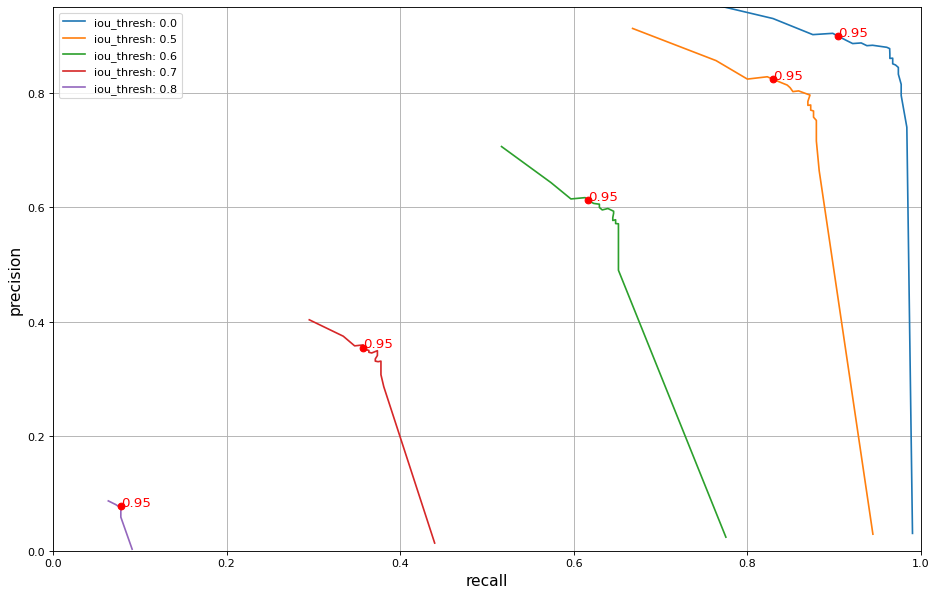

'\nfig = plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor=\'w\', edgecolor=\'k\')\nax = fig.add_subplot(1, 1, 1)\n\nfor iou_thresh in iou_threshs:\n    ax.plot(metrics[iou_thresh]["recall"],metrics[iou_thresh]["precision"])\nax.set_xlim(0,0.95)\nax.set_ylim(0,0.95)\nax.set_xlabel("recall",fontsize=14)\nax.set_ylabel("precision",fontsize=14)\nax.grid()\nplt.show()\n'

In [96]:
iou_threshs = [0.0,0.5,0.6,0.7,0.8]
confidence_threshs = [0.95]

import pylab as pl


fig = pl.figure(num=None, figsize=(14, 9), dpi=80, facecolor='w', edgecolor='k')
ax = fig.add_subplot(1, 1, 1)

legend=[]
for i,iou_thresh in enumerate(iou_threshs):
    legend.append("iou_thresh: "+str(iou_thresh) )
    color = "C"+str(10+i)
    ax.plot(metrics[iou_thresh]["recall"],metrics[iou_thresh]["precision"],color=color)
    if iou_thresh == 0.8:
        pass


plt.legend(legend, loc='upper left')
for i,iou_thresh in enumerate(iou_threshs):
    for confidence in confidence_threshs:
        df_index = metrics[iou_thresh][metrics[iou_thresh]["confidence_threshs"]==confidence].index.values.astype(int)[0]
        recall = metrics[iou_thresh]["recall"][df_index]
        precision = metrics[iou_thresh]["precision"][df_index]
        pl.text(recall, precision, str(confidence), color="red", fontsize=12)
        ax.plot(recall,precision,"o",color="red")
        #ax.plot((0,recall),(0,precision))
ax.set_xlim(0,1)
ax.set_ylim(0,0.95)
ax.set_xlabel("recall",fontsize=14)
ax.set_ylabel("precision",fontsize=14)
ax.grid()
plt.show()
    
'''
fig = plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
ax = fig.add_subplot(1, 1, 1)

for iou_thresh in iou_threshs:
    ax.plot(metrics[iou_thresh]["recall"],metrics[iou_thresh]["precision"])
ax.set_xlim(0,0.95)
ax.set_ylim(0,0.95)
ax.set_xlabel("recall",fontsize=14)
ax.set_ylabel("precision",fontsize=14)
ax.grid()
plt.show()
'''

In [46]:
iou_threshs = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
confidence_threshs = [0.0,0.1,0.2,0.3,0.4,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,
                      0.86,0.87,0.88,0.89,0.9,0.91,0.92,0.93,0.94,0.95,0.96,0.97,0.98,0.99]
count = 0
for i,iou_thresh in enumerate(iou_threshs):
    for confidence in confidence_threshs:
        precision = metrics[iou_thresh]["precision"][df_index]

0     0.091205
1     0.078176
2     0.078176
3     0.078176
4     0.078176
5     0.078176
6     0.078176
7     0.078176
8     0.078176
9     0.078176
10    0.078176
11    0.078176
12    0.078689
13    0.078689
14    0.078689
15    0.078689
16    0.078689
17    0.078689
18    0.078689
19    0.078689
20    0.078689
21    0.078689
22    0.078689
23    0.078689
24     0.07541
25    0.072131
26    0.063758
Name: recall, dtype: object

In [58]:
iou_threshs = np.arange(0.1,1,0.1)
confidence_threshs = [0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95]

metric = {{{}}}
for confidence_thresh in confidence_threshs:
    for iou_thresh in iou_threshs:
        metric[confidence_thresh][iou_thresh] = {'p':0,'tp':0,'tn':0,'fn':0,'precision':0,'recall':0}

TypeError: unhashable type: 'dict'

In [48]:
iou_matrix = np.array([[29,31,100],[31,25,110]])
tp = 0
fp = 0
iou_thresh = 30
np.amax(iou_matrix, 0)

iou_col_max_index = np.argmax(iou_matrix,0)
print(iou_col_max_index)
iou_row_max = np.amax(iou_matrix,1)
for row in range(0,iou_matrix.shape[0]):
    col = iou_col_max_index[row]
    if iou_matrix[row][col] > iou_thresh and iou_matrix[row][col] == iou_row_max[row]:
        tp += 1
    else:
        fp += 1          
tp

[1 0 1]


0

In [110]:

    
import torch
import pandas as pd


iou_threshs = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
confidence_threshs = [0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95]
length = len(confidence_threshs)

metrics = {}
for iou_thresh in iou_threshs:
    metrics[iou_thresh] = pd.DataFrame({
    'confidence_threshs' : confidence_threshs,
    'p' : [None] * length,
    'tp' : [None] * length,
    'fp' : [None] * length,
    'fn' : [None] * length,
    'precision' : [None] * length,
    'recall' : [None] * length
    })

In [126]:
d =  dataset_dicts["val"][320]
img = cv2.imread(d["file_name"])
visualizer = Visualizer(img[:, :, ::-1], metadata=bumblebee_metadata, scale=0.5)
out = visualizer.draw_dataset_dict(d)
cv2.imshow('window',out.get_image()[:, :, ::-1])
cv2.imwrite("/home/linx123-rtx/Pictures/label_example.png",out.get_image()[:, :, ::-1])
cv2.waitKey()
cv2.destroyAllWindows()

In [130]:
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.95
predictor = DefaultPredictor(cfg)
from detectron2.utils.visualizer import ColorMode
d =  dataset_dicts["val"][320]   
im = cv2.imread(d["file_name"])
outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
v = Visualizer(im[:, :, ::-1],
               metadata=bumblebee_metadata, 
               scale=0.5, 
               instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2.imshow(os.path.basename(d["file_name"]),out.get_image()[:, :, ::-1])
cv2.imwrite("/home/linx123-rtx/Pictures/detectionVal320_95confidence.png",out.get_image()[:, :, ::-1])
cv2.waitKey()
cv2.destroyAllWindows()